# 2023-01-19 • Fit a line

We're working off `2022-10-24 • N-to-1 with lognormal inputs`.

But trying a new detection method.

(Linear regression of voltage against time-post-spike)

Note that, unlike in earlier sims, there is no transmission delay added in the latest sim.

## Setup

I'll put the work from previous notebook in a script (not package, this time)

(Thanks to 'jupytext' extension, this script'll also be a notebook)

In [2]:
include("2023-01-19__[input].jl");

using Revise: 0.001277 seconds (347 allocations: 21.688 KiB)
using MyToolbox: 0.001094 seconds (347 allocations: 21.695 KiB)
using SpikeWorks: 0.001079 seconds (347 allocations: 21.695 KiB)
using Sciplotlib: 0.001144 seconds (347 allocations: 21.695 KiB)
using VoltoMapSim: 0.001049 seconds (347 allocations: 21.695 KiB)
Loading cached output from `C:\Users\tfiers\.phdcache\runsim\2023-01-19__[input]__N=5.jld2` … done
Loading cached output from `C:\Users\tfiers\.phdcache\runsim\2023-01-19__[input]__N=20.jld2` … done
Loading cached output from `C:\Users\tfiers\.phdcache\runsim\2023-01-19__[input]__N=100.jld2` … done
Loading cached output from `C:\Users\tfiers\.phdcache\runsim\2023-01-19__[input]__N=400.jld2` … done
Loading cached output from `C:\Users\tfiers\.phdcache\runsim\2023-01-19__[input]__N=1600.jld2` … done (0.1 s)
Loading cached output from `C:\Users\tfiers\.phdcache\runsim\2023-01-19__[input]__N=6500.jld2` … done (0.4 s)


I disabled STA calculating/caching/loading in there: we're gon work on individual windows.

## Start

We'll tackle the most difficult case.

In [3]:
i = 6

6

In [4]:
N = Ns[i]

6500

In [5]:
sim = sims[i]

Simulation{Nto1System{NeuronModel{NamedTuple{(:v, :u, :gₑ, :gᵢ), NTuple{4, Float64}}, typeof(f!), typeof(has_spiked), typeof(on_self_spike!)}, var"#on_spike_arrival!#7"{Float64, Float64, var"#neuron_type#6"{Int64}}}, CVec{(:v, :u, :gₑ, :gᵢ)}}
Summary: completed. 4.9 spikes/s
Properties: 
       system: Nto1System, x₀: (v = -0.05, u = 0, gₑ = 0, gᵢ = 0), input feed: all 20248738 spikes processed
           Δt: 0.0001
     duration: 600
  stepcounter: 6000000 (complete)
        state: t = 600 seconds, neuron = vars: (v: -0.0377, u: -3.5E-11, gₑ: 3.55E-09, gᵢ: 3.09E-09), Dₜvars: (v: 0.738, u: -2.86E-10, gₑ: -5.15E-07, gᵢ: -4.47E-07)
          rec

: v: [-0.0501, -0.0501, -0.0502, -0.0503, -0.0503, -0.0504, -0.0505, -0.0505, -0.0506, -0.0506  …  -0.0383, -0.0383, -0.0382, -0.0381, -0.0381, -0.038, -0.0379, -0.0378, -0.0378, -0.0377], spiketimes: [0.151, 0.318, 0.514, 0.716, 0.952, 1.16, 1.34, 1.56, 1.69, 1.92  …  598, 598, 598, 598, 599, 599, 599, 599, 600, 600]


In [6]:
spikerate(sim) / Hz  # ..of the single output neuron

4.9

In [7]:
inp = inps[i];

---

So we could fit an STA. then there's one `y` per `x`; a 100 `x`s (for 10 ms post 'arrival').

Or we could do individual windows. Let's do that.
(How many datapoints then?

50 Hz input for 10minutes:

In [8]:
_numspikes = 50Hz*10minutes

3E+04

So 30_000 windows. And 30_000 `y`'s per `x`. (per `t`, actually)

Let's find highest spiking exc neuron

In [9]:
spikerate_

spikerate_ (generic function with 2 methods)

In [10]:
actual_spike_rates = spikerate_.(inp.inputs);

In [11]:
for f in [minimum, median, mean, maximum]
    println(lpad(f, 8), ": ", f(actual_spike_rates), " Hz")
end

 minimum: 0.373 Hz
  median: 4.04 Hz
    mean: 5.19 Hz
 maximum: 51.6 Hz


In [12]:
Nₑ = inp.Nₑ

5200

In [13]:
_, ni = findmax(actual_spike_rates)

(51.6, 4562)

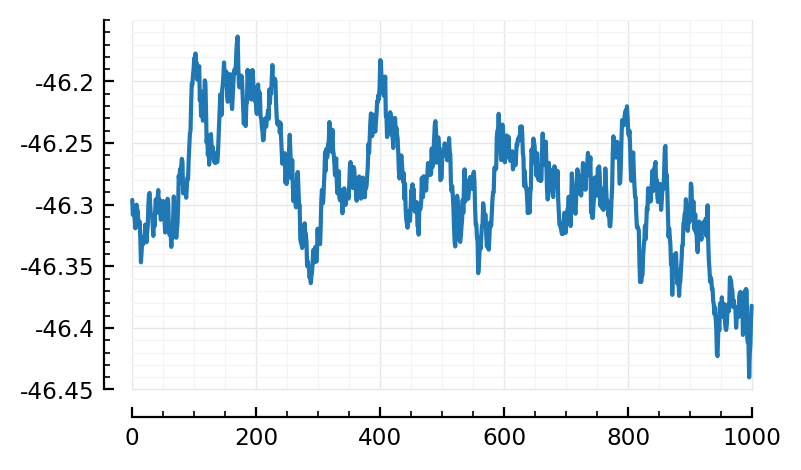

In [14]:
calcSTA(ni) = calcSTA(sim, spiketimes(inp.inputs[ni]))

plot(calcSTA(ni) / mV);

But we're not fitting STAs, we're fitting indiv windows.
So.

## Windows

In [15]:
function windows(v, times, Δt, winsize)
    # Assuming that times occur in [0, T)
    win_starts = floor.(Int, times / Δt) .+ 1
    wins = Vector{Vector{eltype(v)}}()
    for a in win_starts
        b = a + winsize - 1
        if b ≤ lastindex(v)
            push!(wins, v[a:b])
        end
    end
    return wins
end

windows(spiketimes) = windows(
    vrec(sim),
    spiketimes,
    Δt,
    winsize,
)

windows(i::Int) = windows(spiketimes(inp.inputs[i]));

In [18]:
# check for type inferrability
# st = spiketimes(inp.inputs[1])
# @code_warntype windows(vrec(sim), st, Δt, winsize)
# ok ✔

In [19]:
@time wins = windows(ni);
println()
print(Base.summary(wins))

  0.144035 seconds (175.57 k allocations: 248.503 MiB, 32.35% compilation time)

30958-element Vector{Vector{Float64}}

Now to make the data matrix

## Data matrix

We'll fit slope and intercept. So each datapoint, each row of X, is `[1, t]`

In [20]:
function build_Xy(windows, timepoints = 1:100)
    T = eltype(eltype(windows))
    N = length(windows) * length(timepoints)
    X = Matrix{T}(undef, N, 2)
    y = Vector{T}(undef, N)
    i = 1
    for win in windows
        for (tᵢ, yᵢ) in zip(timepoints, win[timepoints])
            X[i,:] .= [1, tᵢ]
            y[i] = yᵢ
            i += 1
        end
    end
    @assert i == N + 1
    return (X, y)
end


@time X, y = build_Xy(wins);

  0.760810 seconds (3.64 M allocations: 358.886 MiB, 38.46% gc time, 25.80% compilation time)


In [22]:
# check for type inferrability
# @code_warntype build_Xy(wins, 1:100)
# ok ✔

In [23]:
size(X)

(3095800, 2)

In [24]:
size(y)

(3095800,)

Some example data:

In [25]:
_r = 95:105

[X[_r, :] y[_r] / mV]

11×3 Matrix{Float64}:
 1   95  -49.5
 1   96  -49.5
 1   97  -49.5
 1   98  -49.4
 1   99  -49.4
 1  100  -49.4
 1    1  -49.1
 1    2  -49.1
 1    3  -49.1
 1    4  -49.1
 1    5  -49.1

So for our model `y = ax + b`  (w/ `β = [b, a]`)

`x` is in units of 'timestep'\
So `a` will be too: mV/timestep

## Solve

Linear regression *assuming Gaussian noise* → MSE, 'OLS', normal equations

`?\` → "`\(X,y)` for rectangular `X`:\
minimum-norm least squares solution computed by \
a pivoted QR factorization of `X` \
and a rank estimate of `X` based on the R factor"


In [28]:
@time β̂ = X \ y

  0.059550 seconds (33 allocations: 70.924 MiB)


2-element Vector{Float64}:
 -0.0463
  6.57E-07

In [29]:
intercept = β̂[1] / mV

-46.3

Ok check

For the slope,

In [30]:
slope = β̂[2] / mV

0.000657

That's per timestep.

Per second:

In [31]:
slope / Δt

6.57

## Plot some windows

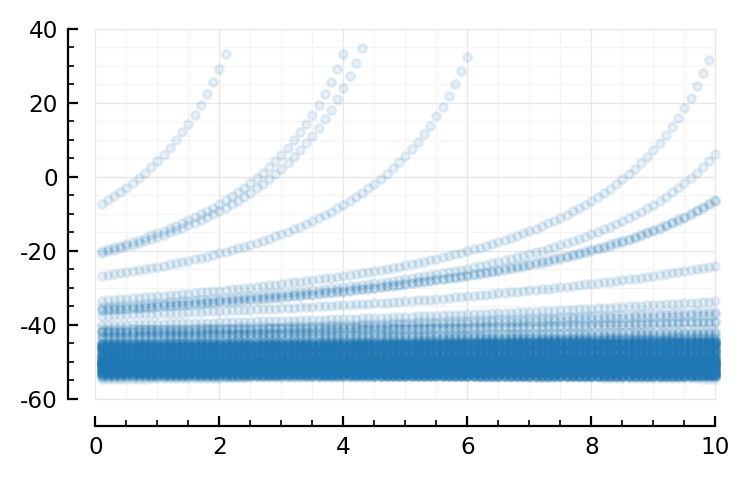

In [96]:
ts = @view X[:,2]
sel = 1:10000

plot(ts[sel]*Δt/ms, y[sel]/mV, ".", alpha=0.1);

It's the spikes we see there.

so let's zoom in

In [110]:
Ny = length(y)

3095800

3M datapoints (one connection, 10 minutes recording)

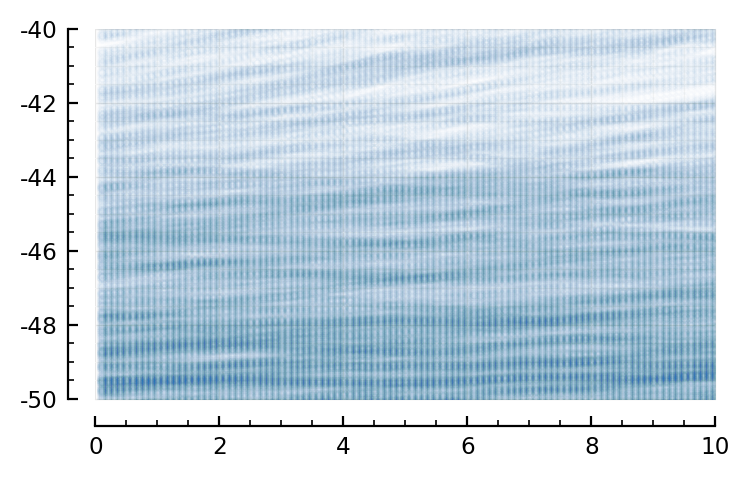

In [114]:
sel = 1:100_000

plot(
    ts[sel]*Δt/ms,
    y[sel]/mV,
    ".";
    alpha = 0.01,
    ylim = [-50, -40],  # mV
    clip_on = true,
);

## Use as conntest

(We could look at uncertainty / goodness of fit but not now)

First, let's see what fitted slope is for an inh input; and a shuffled one.

In [32]:
inh_neurons = Nₑ+1:N

5201:6500

In [33]:
niᵢ = Nₑ + argmax(actual_spike_rates[inh_neurons])

6080

In [34]:
actual_spike_rates[niᵢ] / Hz

39.9

In [35]:
"""
Fit straight line to first 100 ms of
windows cut out of output neuron's voltage signal,
aligned to given times `z`
(or spiketimes of input neuron w/ index `z`).
"""
fitwins(z) = begin
    wins = windows(z)
    X, y = build_Xy(wins)
    β̂ = vec(X \ y)
    ŷ = X * β̂
    ε̂ = y .- ŷ
    return (;
        X, y, β̂,
        intercept   = β̂[1] / mV,       # in mV
        slope       = β̂[2] / mV / Δt,  # in mV/second
        predictions = ŷ,
        residuals   = ε̂,
    )
end;

In [37]:
# check for type inferrability
# @code_warntype fitwins(niᵢ)
# ok ✔

In [38]:
@time fitwins(niᵢ).slope

  0.477347 seconds (2.46 M allocations: 536.014 MiB, 17.74% gc time, 19.87% compilation time)


-16.2

In [39]:
niₑ = ni

4562

In [40]:
@time fitwins(niₑ).slope

  0.535695 seconds (3.16 M allocations: 692.900 MiB, 18.84% gc time)


6.57

In [42]:
spiketimes(i::Int) = spiketimes(inp.inputs[i])

stₑ = spiketimes(niₑ)

@time fitwins(shuffle_ISIs(stₑ)).slope

  0.412741 seconds (3.16 M allocations: 693.462 MiB)


-7.97

Okido

Now, to use as conntest.

Null hypothesis is that slope = 0

Refresher at
https://gregorygundersen.com/blog/2021/09/09/ols-hypothesis-testing/

### Hypothesis testing

If the slope actually were 0\
(i.e. $b_p = b_1 = 0$ in the post),

(and if noise were gaussian, which it's not given the assymetric spiking)

then we expect the slope ("$β̂_1$"), to be distributed as:

$$
\hat{β}_1 \sim \mathcal{N}(0, σ² Q_{[2,2]})
$$
where $Q$ is the inverse of the Gram matrix $X^T X$:

$$
Q = (X'X)^{-1}
$$

($Q$ 'is related to' the covariance matrix, and is called the cofactor matrix.\
https://en.wikipedia.org/wiki/Ordinary_least_squares#Estimation)

..and with $σ$ the (unkown) standard-deviation of our
supposedly-Gaussian-distributed noise $ε$ in our model

$$
y_i = β_0 + β_1 x_i + ε_i,
$$
i.e.

$$
ε \sim \mathcal{N}(0, σ²).
$$

('$Q_{[2,2]}$' is the second diagonal element of $Q$.
The indices are off-by-one as the intercept is conventionally $β_0$ instead of $_1$).

### Estimate noise on model

In [47]:
n = length(fit.y)
p = 2  # Num params
dof = n - p

3095798

In [49]:
fit = fitwins(niₑ)
ε̂ = fit.residuals;

OLS estimate of variance σ² of Gaussian noise ε:

In [51]:
s² = ε̂' * ε̂ / dof

6.78E-05

MLE estimate:

In [53]:
σ̂² = ε̂' * ε̂ / n

6.78E-05

(ofc virtually same cause ridic amount of datapoints)

So estimate for stddev of noise on our line, in mV:

In [55]:
√s² / mV

8.23

Seems about right.

### Gram matrix

In [57]:
X = fit.X
N = X' * X

2×2 Matrix{Float64}:
 3.1E+06   1.56E+08
 1.56E+08  1.05E+10

In [58]:
Q = inv(N)

2×2 Matrix{Float64}:
  1.31E-06  -1.96E-08
 -1.96E-08   3.88E-10

So, estimated stddev of our slope distribution.

In [66]:
σ̂β₂ = √(s² * Q[2,2])

1.62E-07

In [68]:
σ̂β₂ / mV

0.000162

Aka standard error or 'se($β̂₂$)'

### t-statistic

Slope in mV:

In [65]:
fit.slope

6.57

In original units of the (X,y) fit, i.e. volt/timestep:

In [64]:
β̂₂ = fit.β̂[2]

6.57E-07

In [69]:
t = β̂₂ / σ̂β₂

4.06

That value follows the Student's t-distribution with `n-p` degrees of freedom,\
which, at our

In [70]:
dof

3095798

is same as Normally distributed.

In [78]:
using Distributions

In [81]:
𝒩 = Normal()

Normal{Float64}(μ=0, σ=1)

Null-hypothesis is that slope == 0.\
So alternative is that it can be both larger and smaller.

Critical values:

In [84]:
α = 0.05

0.05

In [87]:
quantile(𝒩, α/2)

-1.96

In [88]:
cquantile(𝒩, α/2)

1.96

So yes our slope is significant.

By how much, i.e. what's p-value

I.e. probability of `t` being at least this large, under H₀.

In [91]:
pval = cdf(𝒩, -t) + ccdf(𝒩, t)

5.01E-05

i.e. p = 0.00005 < 0.05

This happens by chance once in

In [94]:
1/pval

2E+04

20_000 universes.

Now to package this up in a function

### Summary

In [121]:
function htest(fit)
    (; X, y, β̂) = fit
    n = length(y)
    p = 2  # Num params
    dof = n - p
    ε̂ = fit.residuals
    s² = ε̂' * ε̂ / dof
    Q = inv(X' * X)
    σ̂β₂ = √(s² * Q[2,2])
    t = β̂[2] / σ̂β₂
    𝒩 = Normal(0, 1)
    pval = cdf(𝒩, -abs(t)) + ccdf(𝒩, abs(t))
    noise_mV = √s² / mV
    return (; t, pval, noise_mV)
end;

In [122]:
htest(fit)

(t = 4.06, pval = 5.01E-05, noise_mV = 8.23)

In [123]:
function conntest(z; α = 0.05)
    fit = fitwins(z)
    test = htest(fit)
    if test.pval < α
        predtype = (fit.slope > 0 ? :exc : :inh)
    else
        predtype = :unconn
    end
    return (;
        fit.slope,
        test.pval,
        predtype,
    )
end;

In [117]:
conntest(niₑ)

(slope = 6.57, pval = 5.01E-05, predtype = :exc)

In [118]:
conntest(niᵢ)

(slope = -16.2, pval = 1.29E-18, predtype = :inh)

In [124]:
conntest(shuffled(niₑ))

(slope = 1.48, pval = 0.369, predtype = :unconn)

In [125]:
conntest(shuffled(niₑ))

(slope = -2.24, pval = 0.172, predtype = :unconn)

In [126]:
conntest(shuffled(niᵢ))

(slope = -1.92, pval = 0.308, predtype = :unconn)

That works nicely!

Let's try on shuffled spiketrains

## Eval

In [119]:
shuffled(ni) = shuffle_ISIs(spiketimes(ni));

In [120]:
DataFrame(conntest(shuffled(niₑ)) for _ in 1:10)

Row,slope,pval,predtype
,Float64,Float64,Symbol
1,-0.44,0.789,unconn
2,2.41,0.143,unconn
3,-3.85,0.0206,inh
4,1.82,0.267,unconn
5,2.96,0.0745,unconn
6,6.58,5.82E-05,exc
7,-6.37,0.000107,inh
8,-4.27,0.00804,inh
9,5.07,0.00196,exc
